/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_7019/3137260173.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_data['Date'] = pd.to_datetime(combined_data['Date'])


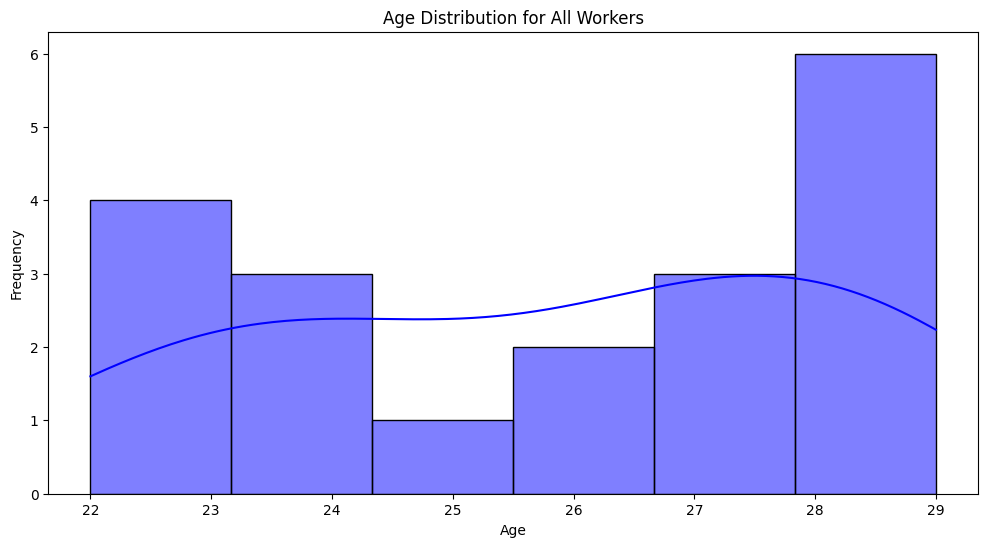

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_7019/3137260173.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=demographic_data['Skill_Level'], palette='viridis')


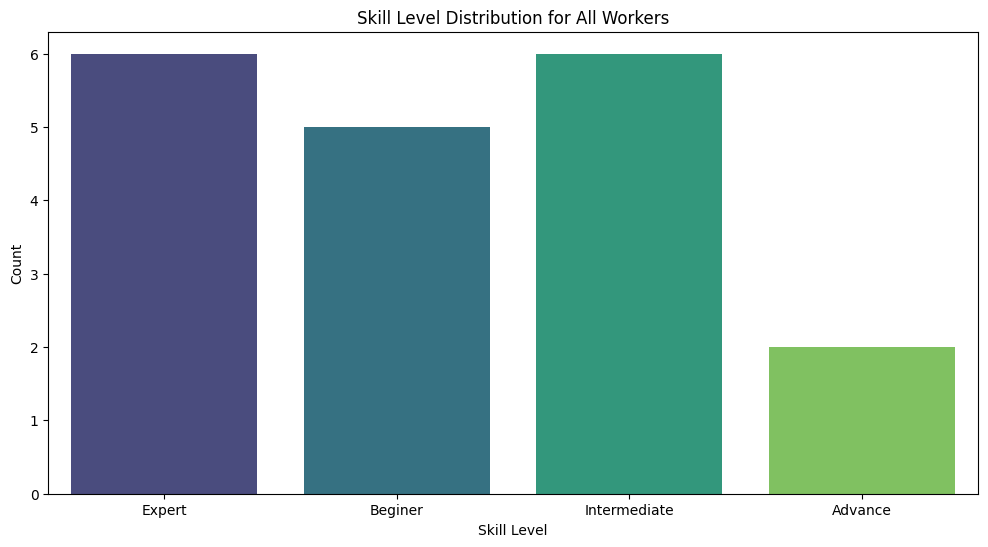

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_7019/3137260173.py:50: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_week_data = worker_data.last('7D')


Worker Name: Maleesha Dewmini
Last week's high defect type: High_Low_D4 with count: 23
Last week's low defect type: Open_Seam_D2 with count: 8

RandomForest: Mean CV MSE = 4.9902069941845
GradientBoosting: Mean CV MSE = 4.9924901308966625
LinearRegression: Mean CV MSE = 4.9924901308966625
SupportVector: Mean CV MSE = 5.533333333333333

Best model: RandomForest with Mean CV MSE = 4.9902069941845

Future defect predictions for worker W_00002:
            Run_Off_D1  Open_Seam_D2  SPI_Errors_D3  High_Low_D4
2024-03-05    2.900414      2.262737       2.327695     2.432748
2024-03-06    2.684188      2.282261       2.454629     2.462116
2024-03-07    2.651203      2.285411       2.469393     2.466017
2024-03-08    2.646171      2.285919       2.471111     2.466535
2024-03-11    2.645404      2.286001       2.471310     2.466604
2024-03-12    2.645287      2.286015       2.471334     2.466613
2024-03-13    2.645269      2.286017       2.471336     2.466614
2024-03-14    2.645266      2.28601

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

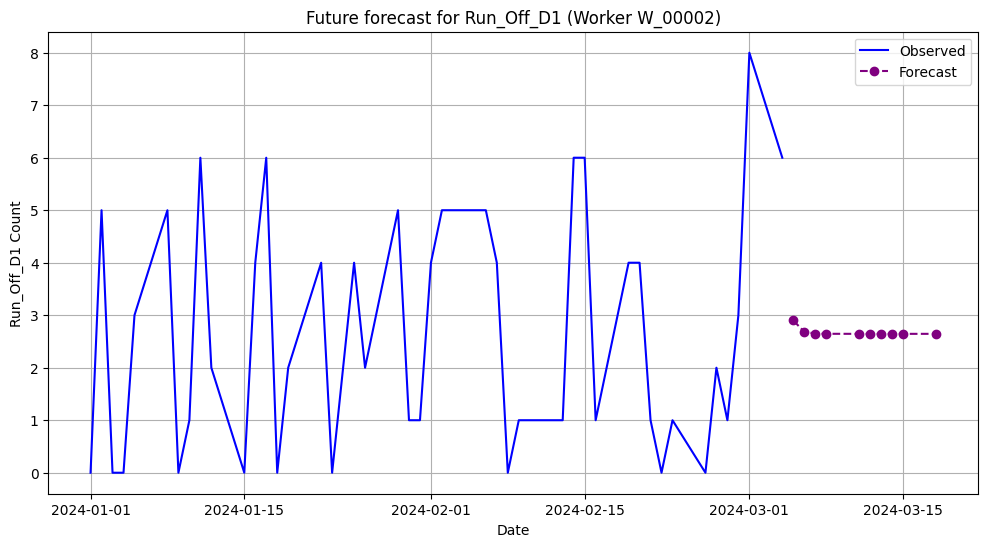

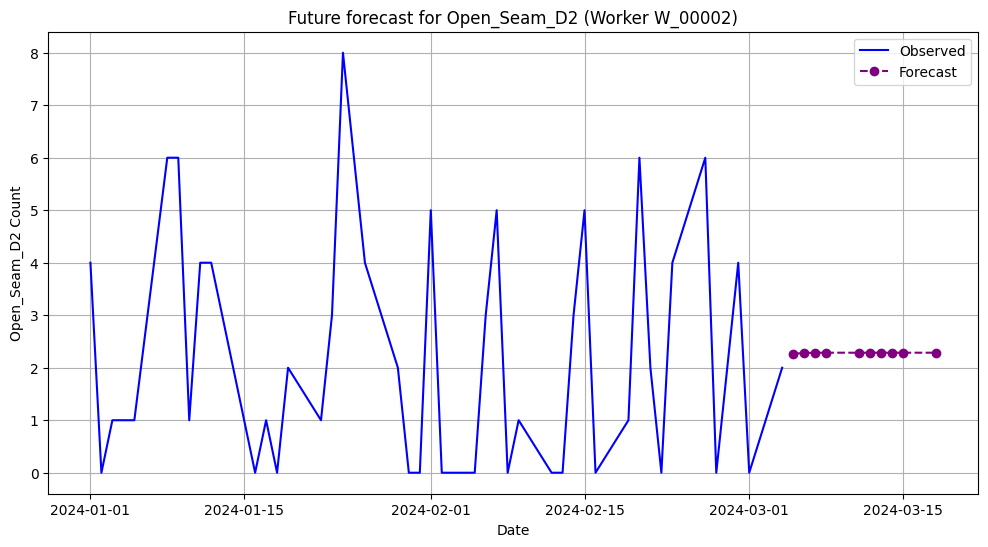

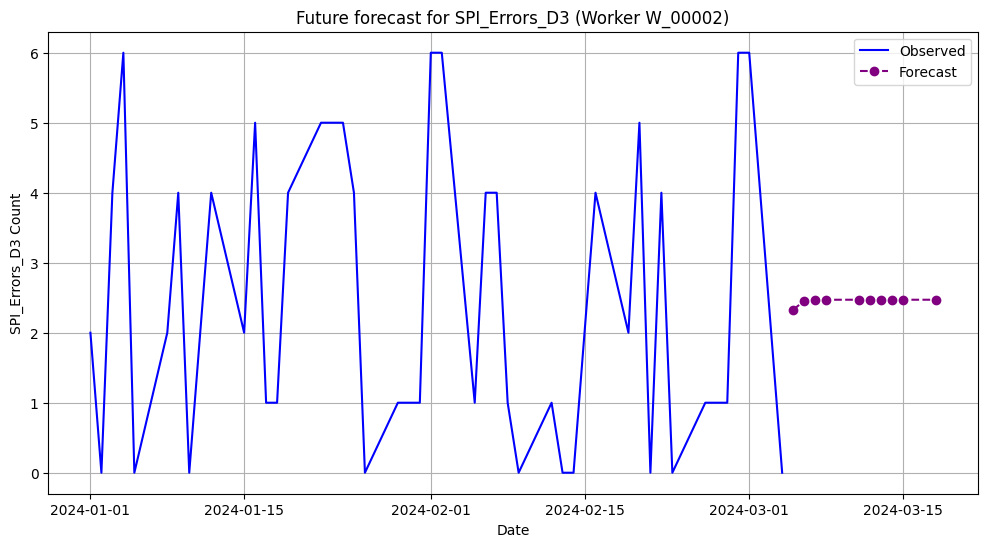

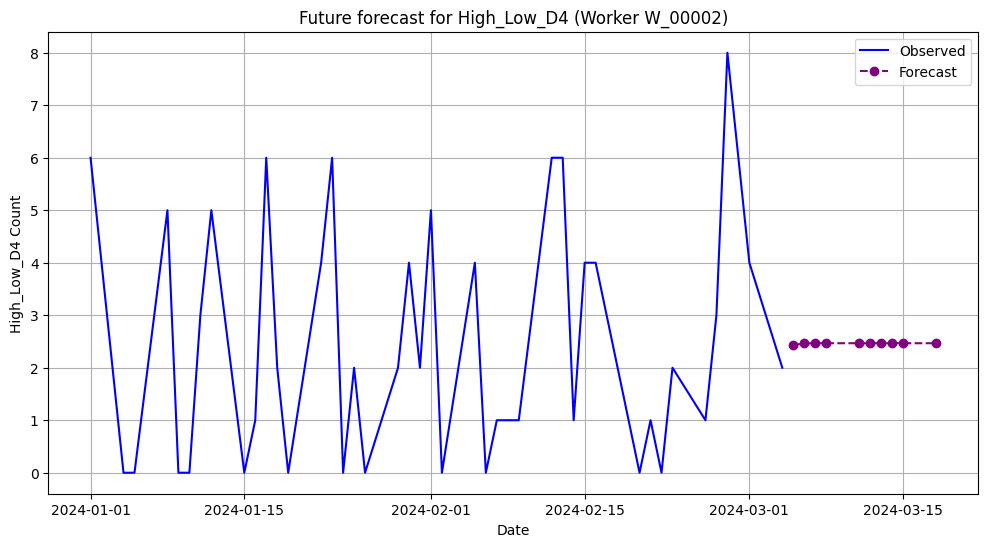

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Read the data
demographic_data = pd.read_csv('demographic_data_dataset.csv')
defect_data = pd.read_csv('updated_worker_defect_details.csv')

# Combine datasets on Worker_ID
combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# Drop unnecessary columns
fields_to_drop = ['Joining_Date', 'Gender']
combined_data.drop(columns=fields_to_drop, inplace=True)

# Convert Date column to datetime and set Date as index for ARIMA
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data.set_index('Date', inplace=True)

def train_arima_model(data, order=(1, 1, 1), steps=10):
    try:
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=steps)
        return model_fit, forecast
    except Exception as e:
        print(f"An error occurred while training the ARIMA model: {e}")
        return None, np.full(steps, np.nan)

def analyze_worker(worker_id, forecast_steps=10):
    worker_data = combined_data[combined_data['Worker_ID'] == worker_id]
    worker_name = demographic_data.loc[demographic_data['Worker_ID'] == worker_id, 'Name'].values[0]

    if worker_data.empty:
        print(f"No data found for worker {worker_id}.")
        return

    # Calculate last week's high and low defect types and their counts
    last_week_data = worker_data.last('7D')
    last_week_summary = last_week_data[['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']].sum()
    last_week_high_defect_type = last_week_summary.idxmax()
    last_week_low_defect_type = last_week_summary.idxmin()
    last_week_high_defect_count = last_week_summary.max()
    last_week_low_defect_count = last_week_summary.min()

    # Print worker details
    print(f"Worker Name: {worker_name}")
    print(f"Last week's high defect type: {last_week_high_defect_type} with count: {last_week_high_defect_count}")
    print(f"Last week's low defect type: {last_week_low_defect_type} with count: {last_week_low_defect_count}")
    print()

    # Define categorical and numerical features
    categorical_features = ['Skill_Level']
    numerical_features = ['Age', 'Production_Volume']

    # Define preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ]
    )

    # Separate features and target variables for the worker
    X_worker = worker_data.drop(columns=['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4', 'defect_count', 'count', 'Worker_ID', 'Shift', 'Name'])
    y_worker = worker_data[['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']]

    # Define and train multiple traditional models
    models = {
        'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
        'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
        'LinearRegression': MultiOutputRegressor(LinearRegression()),
        'SupportVector': MultiOutputRegressor(SVR())
    }

    # Evaluate each model using cross-validation and select the best model
    results = {}
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        cv_scores = cross_val_score(pipeline, X_worker, y_worker, cv=5, scoring='neg_mean_squared_error')
        results[model_name] = -cv_scores.mean()  # Negate because cross_val_score uses negative MSE
        print(f"{model_name}: Mean CV MSE = {-cv_scores.mean()}")
    print()

    best_model_name = min(results, key=results.get)
    best_model = models[best_model_name]

    print(f"Best model: {best_model_name} with Mean CV MSE = {results[best_model_name]}")
    print()

    # Train the best model on the full worker data
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', best_model)
    ])
    pipeline.fit(X_worker, y_worker)

    # Prepare features for the specific worker for future predictions
    X_worker_future = pd.concat([X_worker.iloc[-1:].copy()] * forecast_steps, ignore_index=True)

    # Generate future predictions using the best traditional model
    y_pred_best_model = pipeline.predict(X_worker_future)

    # Generate ARIMA forecasts for each defect type
    arima_forecasts = {}
    for defect_type in ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']:
        model_fit, forecast = train_arima_model(worker_data[defect_type].dropna(), steps=forecast_steps)
        arima_forecasts[defect_type] = forecast

    # Combine traditional model predictions with ARIMA forecasts
    combined_predictions = {}
    for defect_type in ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']:
        combined_predictions[defect_type] = (y_pred_best_model[:, ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4'].index(defect_type)] + arima_forecasts[defect_type]) / 2

    # Print future predictions
    future_dates = pd.date_range(start=worker_data.index[-1], periods=forecast_steps + 1, freq='B')[1:]
    future_predictions = pd.DataFrame(combined_predictions, index=future_dates)

    print(f"Future defect predictions for worker {worker_id}:")
    print(future_predictions)

    # Plotting the results
    for defect_type in ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']:
        plt.figure(figsize=(12, 6))
        plt.plot(worker_data.index, worker_data[defect_type], label='Observed', color='blue')
        plt.plot(future_dates, future_predictions[defect_type], label='Forecast', linestyle='--', marker='o', color='purple')
        plt.title(f'Future forecast for {defect_type} (Worker {worker_id})')
        plt.xlabel('Date')
        plt.ylabel(f'{defect_type} Count')
        plt.legend()
        plt.grid(True)
        plt.show()

# Function to perform demographic analysis for all workers
def demographic_analysis_all():
    plt.figure(figsize=(12, 6))
    sns.histplot(demographic_data['Age'], kde=True, color='blue')
    plt.title('Age Distribution for All Workers')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(x=demographic_data['Skill_Level'], palette='viridis')
    plt.title('Skill Level Distribution for All Workers')
    plt.xlabel('Skill Level')
    plt.ylabel('Count')
    plt.show()

# Perform demographic analysis for all workers
demographic_analysis_all()

# Prompt user to enter Worker ID for defect prediction
worker_id = input("Enter the Worker ID: ")
analyze_worker(worker_id)
